# Supporting Material: Acute Stroke Unit Model

This Jupyter notebook provides an implementation of a Discrete-Event Simulation (DES) model developed for analyzing and planning capacity in acute stroke services. The model is based on the framework described in the paper, 'A modelling tool for capacity planning in acute and community stroke services' by Monks et al. (2016), published in BMC Health Services Research.

The notebook simulates patient flows in an acute stroke unit, focusing on metrics such as bed utilisation and wait times across different patient groups (e.g., Stroke, TIA, ComplexNeuro, and Other). The model is designed to provide insights into the resource needs and performance of acute stroke services, supporting capacity planning and optimisation in healthcare settings.

## Setup
Importing the relevant libaries.

In [1]:
import numpy as np
import pandas as pd
import warnings
import itertools
import math
from scipy.stats import t
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import simpy

simpy.__version__

'4.1.1'

# 1.0 Utility functions

This section defines three distribution classes for the simulation:

- Exponential: Models inter-arrival times with a given mean.
- Lognormal: Models lengths of stay with specified mean and standard deviation.
- Bernoulli: Models binary events, such as the probability of transferring a patient to ESD.

A trace function is included for debugging, controlled by the TRACE constant. These utilities support key simulation processes.

## 1.1 Distribution classes

In [2]:
class Exponential:
    """
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    """

    def __init__(self, mean, random_seed=None):
        """
        Constructor

        Params:
        ------
        mean: float
            The mean of the exponential distribution

        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        """
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean

    def sample(self, size=None):
        """
        Generate a sample from the exponential distribution

        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        """
        return self.rand.exponential(self.mean, size=size)


class Lognormal:
    """
    Encapsulates a lognormal distirbution
    """

    def __init__(self, mean, stdev, random_seed=None):
        """
        Params:
        -------
        mean = mean of the lognormal distribution
        stdev = standard dev of the lognormal distribution
        """
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma

    def normal_moments_from_lognormal(self, m, v):
        """
        Returns mu and sigma of normal distribution
        underlying a lognormal with mean m and variance v
        source: https://blogs.sas.com/content/iml/2014/06/04/simulate-lognormal
        -data-with-specified-mean-and-variance.html

        Params:
        -------
        m = mean of lognormal distribution
        v = variance of lognormal distribution

        Returns:
        -------
        (float, float)
        """
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2 / phi)
        sigma = math.sqrt(math.log(phi**2 / m**2))
        return mu, sigma

    def sample(self):
        """
        Sample from the normal distribution
        """
        return self.rand.lognormal(self.mu, self.sigma)


class Bernoulli:
    """
    Convenience class for the Bernoulli distribution.
    packages up distribution parameters, seed and random generator.
    """

    def __init__(self, p, random_seed=None):
        """
        Constructor

        Params:
        ------
        p: float
            probability of drawing a 1

        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        """
        self.rand = np.random.default_rng(seed=random_seed)
        self.p = p

    def sample(self, size=None):
        """
        Generate a sample from the exponential distribution

        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        """
        return self.rand.binomial(n=1, p=self.p, size=size)

## 1.2 Tracing function

In [3]:
def trace(msg):
    """
    Utility function for printing simulation
    set the TRACE constant to FALSE to
    turn tracing off.

    Params:
    -------
    msg: str
        string to print to screen.
    """
    if TRACE:
        print(msg)

# 2.0 Model Setup
This code defines key parameters for the acute stroke unit model, including the number of beds (N_BEDS), inter-arrival times for different patient types (using exponential distributions), and length of stay (LOS) for each patient type (using lognormal distributions). It also sets the probability of stroke patients being transferred to Early Supported Discharge (ESD) via a Bernoulli distribution. Additionally, it allows for reproducible simulation results using predefined random seeds.

## 2.1 Model parameters

In [4]:
N_BEDS = 10

# Time between arrivals in days (exponential)
MEAN_IAT_STROKE = 1.2
MEAN_IAT_TIA = 9.3
MEAN_IAT_CN = 3.6
MEAN_IAT_OTHER = 3.2

# Acute stroke unit length of stay in days (lognormal)
STAY_PARAMS = {
    "Stroke": (7.4, 8.6),
    "Stroke_ESD": (4.6, 4.8),
    "TIA": (1.8, 2.3),
    "ComplexNeuro": (4.0, 5.0),
    "Other": (3.8, 5.2),
}

# Transfer (Bernoulli)
PROB_ESD = 0.1711

# SEEDS to reproduce results of a single run
REPRODUCIBLE_RUN = False

if REPRODUCIBLE_RUN:
    SEEDS = [42, 101, 1066, 1966, 2013, 999, 1444, 2016]
else:
    SEEDS = [None] * 8

## 2.2 Scenerio class
The Scenario class acts as a container for the parameters of the acute stroke unit model. It initialises the default values for inter-arrival times of different patient types (stroke, TIA, complex neuro, and other), the number of beds, and the length of stay distributions for each patient type using lognormal distributions. It also defines the probability of stroke patients being transferred to Early Supported Discharge (ESD) via a Bernoulli distribution. The class contains methods to initialize the random number generation for patient arrivals, store results, and set random seeds for reproducibility. The set_random_seed method allows for setting custom seeds to ensure consistent results across simulations.

In [5]:
class Scenario:
    """Parameter container class for acute stroke unit model."""

    def __init__(
        self,
        iat_stroke=MEAN_IAT_STROKE,
        iat_tia=MEAN_IAT_TIA,
        iat_cn=MEAN_IAT_CN,
        iat_other=MEAN_IAT_OTHER,
        name=None,
    ):
        """
        Initializes the Scenario class.

        Parameters:
        -----------
        name : str or None
            Optional name for the scenario.
        """
        self.name = name  # Optional name

        self.unit_beds = N_BEDS
        self.unit_beds_capacity = N_BEDS

        # Store the parameters
        self.iat_stroke = iat_stroke
        self.iat_tia = iat_tia
        self.iat_cn = iat_cn
        self.iat_other = iat_other

        # Initialize patient arrival distribution
        self.init_sampling()
        self.patients = []

        # Initialize Length of Stay distributions for all patient types
        self.length_of_stay_dist = {
            patient_type: Lognormal(mean, std, random_seed=SEEDS[4])
            for patient_type, (mean, std) in STAY_PARAMS.items()
        }

        # ESD transfer: probability that patient goes to ESD
        self.esd_transfer = Bernoulli(PROB_ESD, random_seed=SEEDS[5])
        trace(f"ESD Transfer Probability: {PROB_ESD}")

    def init_sampling(self):
        """
        Initialises inter-arrival distribution for different patient
        types.
        """
        self.arrival_dist = {
            "Stroke": Exponential(MEAN_IAT_STROKE, random_seed=SEEDS[0]),
            "TIA": Exponential(MEAN_IAT_TIA, random_seed=SEEDS[1]),
            "ComplexNeuro": Exponential(MEAN_IAT_CN, random_seed=SEEDS[2]),
            "Other": Exponential(MEAN_IAT_OTHER, random_seed=SEEDS[3]),
        }

    def set_random_no_set(self, random_no_set):
        """Sets the random number seed for reproducibility."""
        np.random.seed(random_no_set)

    def set_random_seed(self, seed=None):
        """Sets a random seed and re-initializes sampling distributions."""
        if seed is None:
            seed = np.random.randint(0, 2**32 - 1)

        np.random.seed(seed)
        self.init_sampling()

# 3.0 Modelling the unit

The code models the Acute Stroke Unit using two main components: AcuteStrokeUnit and AcutePatient. 
- The AcuteStrokeUnit class handles the simulation environment, initialising resources (e.g., beds) and managing patient arrivals for different types (stroke, TIA, complex neuro, and other). Each patient type has its own arrival generator function that creates new patient instances at specified inter-arrival times using the Exponential distribution. 
- The AcutePatient class represents an individual patient and models their stay in the unit, including bed assignment, length of stay, and potential transfer to ESD. The patient’s length of stay is determined by a lognormal distribution, and the Bernoulli distribution is used to decide if a stroke patient will transfer to ESD. Both classes work together to simulate the flow of patients through the unit, tracking key metrics such as time to bed and length of stay.
- The script runs the model in a simpy environment, simulating patient arrivals and processing for a predefined duration (RUN_LENGTH). After the simulation, the model calculates bed utilisation and outputs the results.


## 3.1 Modelling the Acute Stroke Unit

In [38]:
class AcuteStrokeUnit:
    """Model of an acute stroke unit."""

    def __init__(self, env, args):
        """
        Constructor.

        Params:
        -------
        env: simpy.Environment
            Simulation environment.

        args: Scenario
            Container class for simulation model inputs.
        """
        self.env = env
        self.args = args
        self.init_model_resources(args)
        self.args.total_bed_time_used = 0
        self.patients = []

        # Shared patient ID counter
        self.patient_id_counter = 0

        # Start arrival processes for different patient types
        env.process(self.stroke_arrivals_generator())
        env.process(self.tia_arrivals_generator())
        env.process(self.complexneuro_arrivals_generator())
        env.process(self.other_arrivals_generator())

    def init_model_resources(self, args):
        """
        Setup the simpy resource objects.

        Params:
        -------
        args: Scenario
            Simulation Parameter Container.
        """
        args.unit_beds = simpy.Resource(self.env, capacity=args.unit_beds)

    def start_patient_arrivals(self):
        """Start arrival processes for all patient types."""
        self.env.process(self.stroke_arrivals_generator())
        self.env.process(self.tia_arrivals_generator())
        self.env.process(self.complexneuro_arrivals_generator())
        self.env.process(self.other_arrivals_generator())

    def stroke_arrivals_generator(self):
        """Arrival process for stroke patients."""
        while True:
            inter_arrival_time = self.args.arrival_dist["Stroke"].sample()
            yield self.env.timeout(inter_arrival_time)

            # Increment global counter
            self.patient_id_counter += 1
            new_patient = AcutePatient(
                self.patient_id_counter, self.env, self.args, "Stroke"
            )
            self.patients.append(new_patient)
            self.env.process(new_patient.assessment())

            trace(
                f"Patient {self.patient_id_counter} STROKE arrival at: "
                f"{self.env.now:.3f}"
            )

    def tia_arrivals_generator(self):
        """Arrival process for TIA patients."""
        while True:
            inter_arrival_time = self.args.arrival_dist["TIA"].sample()
            yield self.env.timeout(inter_arrival_time)

            self.patient_id_counter += 1
            new_patient = AcutePatient(
                self.patient_id_counter, self.env, self.args, "TIA"
            )
            self.patients.append(new_patient)
            self.env.process(new_patient.assessment())

            trace(
                f"Patient {self.patient_id_counter} TIA arrival at: "
                f"{self.env.now:.3f}"
            )

    def complexneuro_arrivals_generator(self):
        """Arrival process for ComplexNeuro patients."""
        while True:
            inter_arrival_time = (self.args.arrival_dist["ComplexNeuro"]
                                .sample()
                                 )
            yield self.env.timeout(inter_arrival_time)

            self.patient_id_counter += 1
            new_patient = AcutePatient(
                self.patient_id_counter, self.env, self.args, "ComplexNeuro"
            )
            self.patients.append(new_patient)
            self.env.process(new_patient.assessment())

            trace(
                f"Patient {self.patient_id_counter} ComplexNeuro arrival at: "
                f"{self.env.now:.3f}"
            )

    def other_arrivals_generator(self):
        """Arrival process for Other patients."""
        while True:
            inter_arrival_time = self.args.arrival_dist["Other"].sample()
            yield self.env.timeout(inter_arrival_time)

            self.patient_id_counter += 1
            new_patient = AcutePatient(
                self.patient_id_counter, self.env, self.args, "Other"
            )
            self.patients.append(new_patient)
            self.env.process(new_patient.assessment())

            trace(
                f"Patient {self.patient_id_counter} Other arrival at: "
                f"{self.env.now:.3f}"
            )

## 3.1 Modelling the patient

In [39]:
class AcutePatient:
    """
    Patient in the minor ED process.
    """

    def __init__(self, identifier, env, args, patient_type):
        """
        Constructor method.

        Params:
        -------
        identifier: int
            Unique patient identifier.
        env: simpy.Environment
            Simulation environment.
        args: Scenario
            Container for model parameters.
        patient_type: str
            Type of patient (e.g., Stroke, TIA, etc.).
        """
        self.identifier = identifier
        self.env = env
        self.args = args  # Store scenario parameters
        self.patient_type = patient_type

        # Get length of stay distribution from Scenario
        self.length_of_stay_dist = args.length_of_stay_dist[patient_type]

        self.unit_beds = args.unit_beds

        # ESD transfer probability
        self.esd_transfer = args.esd_transfer

        # Patient metrics
        self.time_to_bed = 0.0
        self.length_of_stay = 0.0
        self.time_to_esd = 0.0
        self.time_in_system = 0.0

    def assessment(self):
        """Simulates the process for acute stroke unit patients."""
        arrival_time = self.env.now

        # Decide whether the patient will transfer to ESD
        raw_esd_decision = self.esd_transfer.sample()

        # Convert 0/1 to True/False for readability
        self.is_esd = self.patient_type == "Stroke" and raw_esd_decision == 1

        with self.unit_beds.request() as req:
            yield req

            bed_time = self.env.now
            trace(
                f"Patient {self.identifier} ({self.patient_type}) "
                f"gets bed at "
                f"{self.env.now:.3f}"
            )

            self.time_to_bed = self.env.now - arrival_time

            # Determine length of stay based on ESD transfer decision
            if self.is_esd:
                self.time_to_esd = self.env.now - bed_time
                length_of_stay = self.args.length_of_stay_dist[
                    "Stroke_ESD"
                ].sample()
            else:
                length_of_stay = self.length_of_stay_dist.sample()

            yield self.env.timeout(length_of_stay)

            self.time_in_system = self.env.now - arrival_time
            self.length_of_stay = self.env.now - bed_time

            trace(
                f"Patient {self.identifier} discharged at {self.env.now:.3f}, "
                f"LOS: {self.length_of_stay:.3f} days, "
                f"Total time in system: {self.time_in_system:.3f} days"
            )

## 3.2 Script to run the model 

In [40]:
# Run length in days
RUN_LENGTH = 1445

# Define trace as on/off
TRACE = False

# Create simpy environment
env = simpy.Environment()

# Base case scenario with default parameters
default_args = Scenario()

# Create the model
model = AcuteStrokeUnit(env, default_args)

# We pass all arrival generators to simpy
env.process(model.stroke_arrivals_generator())
env.process(model.tia_arrivals_generator())
env.process(model.complexneuro_arrivals_generator())
env.process(model.other_arrivals_generator())

# Run the simulation
env.run(until=RUN_LENGTH)

print(f"End of run. Simulation clock time = {env.now}")

# Create a new scenario
scenario = Scenario()

End of run. Simulation clock time = 1445


# 4.0 Running metrics
This section of the code simulates patient flow within an acute care unit, analyzing key performance metrics to assess hospital efficiency. The simulation captures patient types such as Stroke, TIA, Complex Neuro, and Other, computing statistics like mean time in the system, length of stay, and wait time for a bed.

## 4.1 General metrics
For each patient type, the code calculates:

- Mean Time in System (from arrival to discharge).
- Mean Length of Stay (from bed assignment to discharge).
- Mean Time to Bed (from arrival to bed assignment).

Additionally, for Stroke patients only, the model evaluates Early Supported Discharge (ESD) transfers, computing the proportion of patients transferred and their mean length of stay.

In [41]:
if model.patients:
    # Group patients by their type (e.g., "Stroke", "TIA", etc.)
    patient_types = {p.patient_type for p in model.patients}
    for patient_type in patient_types:
        # Filter patients by type
        patients_by_type = [
            p for p in model.patients if p.patient_type == patient_type
        ]

        # 1. Mean time in system (from arrival to discharge)
        mean_time_in_system = np.mean(
            [p.time_in_system for p in patients_by_type]
        )

        # 2. Mean length of stay (from bed assignment to discharge)
        discharged_patients = [
            p
            for p in patients_by_type
            if hasattr(p, "length_of_stay") and p.length_of_stay > 0
        ]
        mean_length_of_stay = (
            np.mean([p.length_of_stay for p in discharged_patients])
            if discharged_patients
            else 0
        )

        # 3. Mean time to bed (arrival → bed assignment)
        mean_time_to_bed = np.mean([p.time_to_bed for p in patients_by_type])

        print(f"\nResults for {patient_type} Patients\n------------------")
        print(f"Mean Time in System (days): {mean_time_in_system:.2f}")
        print(f"Mean Length of Stay (days): {mean_length_of_stay:.2f}")
        print(f"Mean Time to Bed (days): {mean_time_to_bed:.2f}")

        # Only calculate and print ESD statistics for Stroke patients
        if patient_type == "Stroke":
            esd_patients = [
                p for p in patients_by_type if getattr(p, "is_esd", False)
            ]
            if esd_patients:
                print(f"Number of ESD patients: {len(esd_patients)}")

                # Calculate the mean length of stay for ESD patients
                esd_discharged_patients = [
                    p
                    for p in esd_patients
                    if hasattr(p, "length_of_stay") and p.length_of_stay > 0
                ]
                mean_length_of_stay_esd = (
                    np.mean(
                        [p.length_of_stay for p in esd_discharged_patients]
                    )
                    if esd_discharged_patients
                    else 0
                )
                esd_transfer_rate = len(esd_patients) / len(patients_by_type)
            else:
                mean_length_of_stay_esd = None
                esd_transfer_rate = 0
                print("No ESD patients found.")

            # Print ESD statistics for Stroke patients only
            print(
                f"Mean Length of Stay for ESD Patients (days): "
                f"{mean_length_of_stay_esd:.2f}"
            )
            print(
                f"Proportion of Patients Transferred to ESD: "
                f"{esd_transfer_rate:.2%}"
            )
    else:
        print("No patients recorded in this simulation run.")


Results for Stroke Patients
------------------
Mean Time in System (days): 157.87
Mean Length of Stay (days): 6.76
Mean Time to Bed (days): 155.67
Number of ESD patients: 408
Mean Length of Stay for ESD Patients (days): 4.28
Proportion of Patients Transferred to ESD: 16.84%

Results for Other Patients
------------------
Mean Time in System (days): 161.61
Mean Length of Stay (days): 3.74
Mean Time to Bed (days): 159.23

Results for ComplexNeuro Patients
------------------
Mean Time in System (days): 171.70
Mean Length of Stay (days): 3.70
Mean Time to Bed (days): 170.05

Results for TIA Patients
------------------
Mean Time in System (days): 173.81
Mean Length of Stay (days): 1.68
Mean Time to Bed (days): 172.66
No patients recorded in this simulation run.


## 4.2 Single run
A single simulation execution is performed, summarizing results in a DataFrame, including:
- Bed Utilization (%).
- Average wait time for a bed for each patient type.

In [42]:
def summarize_results(model):
    """
    Generate a single-row DataFrame with mean results for each patient type.
    """

    if not model.patients:
        print("No patients recorded in this simulation run.")
        return pd.DataFrame()  # Return an empty DataFrame

    patient_types = ["Stroke", "TIA", "ComplexNeuro", "Other"]  # Fixed order
    summary_data = {}

    # Calculate bed utilization
    total_bed_time = sum(
        p.length_of_stay for p in model.patients if p.length_of_stay > 0
    )
    total_time = (
        model.env.now
        * scenario.unit_beds_capacity  # Access unit_beds_capacity
    )
    bed_utilization = (
        (total_bed_time / total_time) * 100 if total_time > 0 else np.nan
    )
    summary_data["Bed_Utilization (%)"] = bed_utilization

    for patient_type in patient_types:
        patients_by_type = [
            p for p in model.patients if p.patient_type == patient_type
        ]

        # Mean wait for bed (time from arrival to bed assignment)
        patients_with_bed = [
            p
            for p in patients_by_type
            if hasattr(p, "time_to_bed") and p.time_to_bed > 0
        ]
        mean_wait_for_bed = (
            np.mean([p.time_to_bed for p in patients_with_bed])
            if patients_with_bed
            else np.nan
        )

        # Store results with modified column names
        summary_data[f"{patient_type}_Wait"] = mean_wait_for_bed

    return pd.DataFrame([summary_data])  # Return as a single-row DataFrame


TRACE = False


def single_run(scenario, rc_period=1445):
    """
    Runs the model for a single scenario and returns
    results as a DataFrame.
    """

    env = simpy.Environment()
    model = AcuteStrokeUnit(env, scenario)

    # Start patient arrival processes
    env.process(model.stroke_arrivals_generator())
    env.process(model.tia_arrivals_generator())
    env.process(model.complexneuro_arrivals_generator())
    env.process(model.other_arrivals_generator())

    env.run(until=rc_period)

    return summarize_results(model)


# Create the default scenario
args = Scenario()

# Run the model
print("Running simulation ...", end=" => ")
results = single_run(args)
print("Simulation complete.")

# Display the DataFrame
results

Running simulation ... => Simulation complete.


,Bed_Utilization (%),Stroke_Wait,TIA_Wait,ComplexNeuro_Wait,Other_Wait
0,98.756301,316.137688,308.465884,310.73422,308.661155


## 4.3 Multiple Replications
To improve accuracy, the simulation is repeated 150 times in parallel to account for randomness. The results are stored in a DataFrame, where each row represents a different run, enabling statistical analysis of hospital performance.

In [43]:
def multiple_replications(scenario, rc_period=1445, n_reps=11, n_jobs=-1):
    """
    Run multiple independent replications of the model and return
    results in a DataFrame. Each row represents a single replication,
    and columns represent patient types.
    """
    # Run multiple replications in parallel
    res = Parallel(n_jobs=n_jobs)(
        delayed(single_run)(Scenario()) for _ in range(n_reps)
    )

    # Concatenate results, keeping each replication as a row
    df_results = pd.concat(res, keys=range(1, n_reps + 1), names=["rep"])

    # Reset index to have 'rep' as a column
    df_results.reset_index(level=0, inplace=True)

    return df_results.set_index("rep")  # Format with reps as rows


# Run multiple replications
args = Scenario()
print("Running multiple replications ... => ", end="")

results = multiple_replications(args, rc_period=1445, n_reps=150, n_jobs=-1)

print("Simulation complete.")

# Display the results
results

Running multiple replications ... => Simulation complete.


,Bed_Utilization (%),Stroke_Wait,TIA_Wait,ComplexNeuro_Wait,Other_Wait
rep,,,,,
1,99.506972,282.101746,237.700759,288.291526,288.305614
2,99.161722,248.929960,261.189449,254.724362,243.263226
3,99.462457,285.727814,280.129590,298.759448,297.678773
4,99.215723,285.770735,278.593396,283.677249,279.855334
5,99.564155,268.685386,270.253990,271.577710,272.542636
...,...,...,...,...,...
146,99.577024,254.786421,253.047014,255.868607,259.970471
147,99.302802,247.635316,253.055372,249.237576,252.922475
148,99.546822,280.919460,282.140837,283.001843,289.317338


In [44]:
results.mean()

Bed_Utilization (%)     99.283710
Stroke_Wait            280.689503
TIA_Wait               279.476368
ComplexNeuro_Wait      282.082107
Other_Wait             280.702502
dtype: float64

## 4.4 Graphical plots of the replications
The final section visualizes the variability in patient wait times using histograms. It plots wait time distributions for Stroke, TIA, Complex Neuro, and Other patients, providing insights into bottlenecks and system efficiency.

Running multiple replications => done.



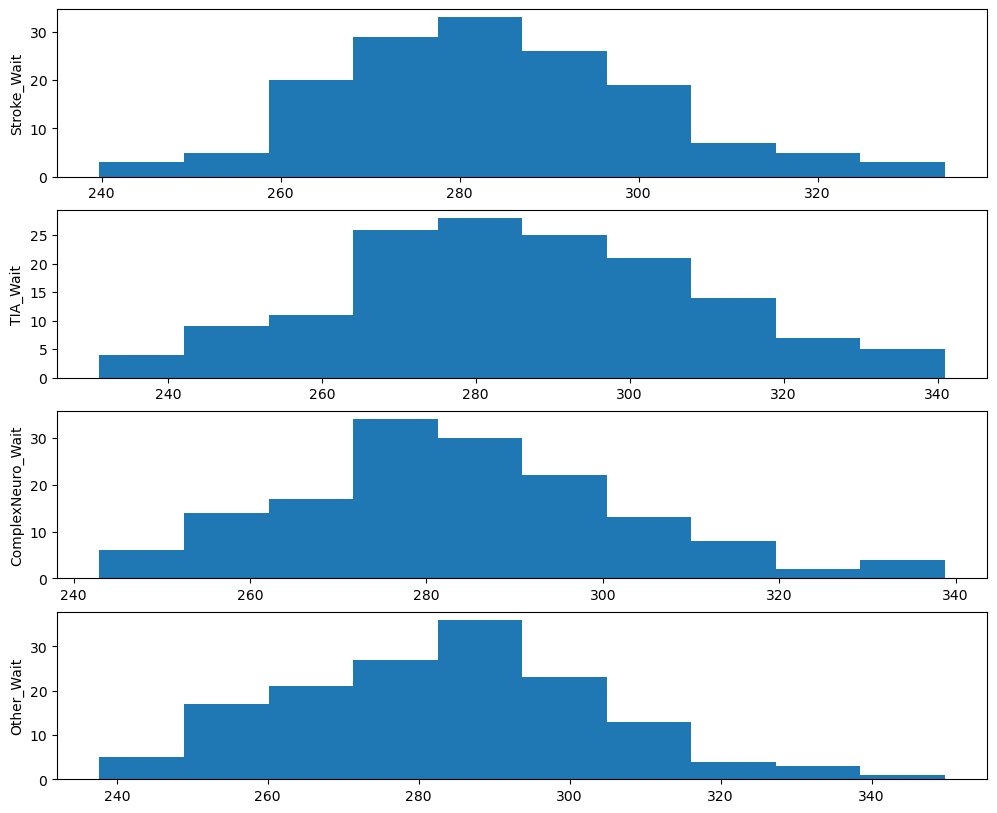

In [45]:
args = Scenario()

# Run multiple replications.
print("Running multiple replications", end=" => ")
results = multiple_replications(args, n_reps=150)
print("done.\n")

fig, ax = plt.subplots(4, 1, figsize=(12, 10))
ax[0].hist(results["Stroke_Wait"])
ax[0].set_ylabel("Stroke_Wait")
ax[1].hist(results["TIA_Wait"])
ax[1].set_ylabel("TIA_Wait")
ax[2].hist(results["ComplexNeuro_Wait"])
ax[2].set_ylabel("ComplexNeuro_Wait")
ax[3].hist(results["Other_Wait"])
ax[3].set_ylabel("Other_Wait");

# 5.0 Calculating Warm up Period

The WarmupAuditor class is used to track key metrics during the warm-up phase of a simulation. It monitors:
- Bed Utilization: Measures how effectively beds are used over time.
- Mean Wait Times: Tracks the average wait time for different patient groups (Stroke, TIA, ComplexNeuro, and Other).

The functions warmup_single_run and warmup_analysis are used to make a time-series for analysis: 
- warmup_single_run: Performs a single warm-up run of the simulation, tracking bed utilization and mean wait times for different patient types (Stroke, TIA, ComplexNeuro, Other) at specified intervals. Returns a DataFrame with the results labeled by replication ID.
- warmup_analysis: Runs multiple replications of the warm-up analysis in parallel using warmup_single_run, collects the results, and combines them into a single DataFrame. The data is also pivoted, with each column representing a replication. Parallel execution speeds up the process using joblib.

In [48]:
def calculate_bed_utilization(model):
    """
    Calculate bed utilization after a simulation step.
    """
    total_bed_time = sum(
        p.length_of_stay for p in model.patients if p.length_of_stay > 0
    )
    total_time = model.env.now * model.args.unit_beds_capacity
    utilization = total_bed_time / total_time if total_time > 0 else 0
    return utilization * 100  # Return as percentage

DEFAULT_WARMUP_AUDIT_INTERVAL = 60  

class WarmupAuditor:
    """
    Warmup Auditor for the model.

    Stores the cumulative means for:
    1. Bed utilization
    2. Mean wait time for each patient group
    """

    def __init__(
        self, model, scenario, interval=DEFAULT_WARMUP_AUDIT_INTERVAL
    ):
        self.env = model.env
        self.model = model
        self.scenario = scenario
        self.interval = interval
        self.bed_utilization = []
        self.stroke_wait = []
        self.tia_wait = []
        self.complexneuro_wait = []
        self.other_wait = []

    def run(self, rc_period):
        """
        Run the audited model.

        Parameters
        ----------
        rc_period : float
            Results collection period.

        Returns
        -------
        None
        """
        self.env.process(self.audit_model())
        self.env.run(until=rc_period)

    def audit_model(self):
        """Audit the model at the specified intervals."""
        for _ in itertools.count():
            yield self.env.timeout(self.interval)

            total_bed_time = sum(
                p.length_of_stay
                for p in self.model.patients
                if p.length_of_stay > 0
            )
            total_time = self.env.now * self.scenario.unit_beds_capacity
            bed_util = (
                (total_bed_time / total_time) * 100 if total_time > 0 else 0
            )

            patient_types = ["Stroke", "TIA", "ComplexNeuro", "Other"]
            wait_times = {}

            for p_type in patient_types:
                patients = [
                    p for p in self.model.patients if p.patient_type == p_type
                ]
                valid_patients = [
                    p.time_to_bed
                    for p in patients
                    if hasattr(p, "time_to_bed") and p.time_to_bed > 0
                ]
                wait_time = np.mean(valid_patients) if valid_patients else 0
                wait_times[p_type.lower() + "_wait"] = wait_time

            self.bed_utilization.append(bed_util)
            self.stroke_wait.append(wait_times["stroke_wait"])
            self.tia_wait.append(wait_times["tia_wait"])
            self.complexneuro_wait.append(wait_times["complexneuro_wait"])
            self.other_wait.append(wait_times["other_wait"])

    def summary_frame(self):
        """
        Return the audit observations in a summary DataFrame.

        Returns
        -------
        pd.DataFrame
        """
        return pd.DataFrame(
            {
                "bed_util": self.bed_utilization,
                "stroke_wait": self.stroke_wait,
                "tia_wait": self.tia_wait,
                "complexneuro_wait": self.complexneuro_wait,
                "other_wait": self.other_wait,
            }
        )

def warmup_analysis(scenario, rc_period, n_reps=11, interval=60, n_jobs=-1):
    """
    Run multiple replications of warm-up analysis in parallel.
    """
    res = Parallel(n_jobs=n_jobs)(
        delayed(warmup_single_run)(scenario, rc_period, interval, rep_id)
        for rep_id in range(n_reps)
    )

    # Combine results into a single DataFrame
    df_warmup = pd.concat(res, ignore_index=True)

    # Reshape: each replication is a column for a specific metric
    df_pivot = df_warmup.pivot(
        index="time", columns="rep", values="Bed_Utilization"
    )

    return df_warmup, df_pivot

In [49]:
def warmup_single_run(scenario, rc_period, interval=60, rep_id=0):
    """
    Perform a single warm-up run and return a DataFrame with results.
    """
    env = simpy.Environment()
    model = AcuteStrokeUnit(env, scenario)

    # Start patient arrival processes
    env.process(model.stroke_arrivals_generator())
    env.process(model.tia_arrivals_generator())
    env.process(model.complexneuro_arrivals_generator())
    env.process(model.other_arrivals_generator())

    data = []
    for time_step in range(0, rc_period, interval):
        env.run(until=time_step + interval)  # Run until next interval
        bed_util = calculate_bed_utilization(model)

        def avg_wait(ptype):
            return np.mean(
                [
                    p.time_to_bed
                    for p in model.patients
                    if p.patient_type == ptype and hasattr(p, "time_to_bed")
                ]
            )

        wait_times = {
            "Stroke_Wait": avg_wait("Stroke"),
            "TIA_Wait": avg_wait("TIA"),
            "ComplexNeuro_Wait": avg_wait("ComplexNeuro"),
            "Other_Wait": avg_wait("Other"),
        }

        data.append(
            {
                "time": time_step + interval,
                "Bed_Utilization": bed_util,
                **wait_times,
            }
        )

    df = pd.DataFrame(data)
    df["rep"] = f"rep_{rep_id + 1}"  # Label as rep_1, rep_2, etc.
    return df

In [50]:
# Run and test
RUN_LENGTH = 1445
N_REPS = 11
scenario = Scenario()

print("Running warm-up analysis with replications. Please wait...", end=" => ")
df_warmup, df_pivot = warmup_analysis(
    scenario, rc_period=RUN_LENGTH, n_reps=N_REPS
)
print("done.")

# Display first few rows of both DataFrames
print("Warm-up DataFrame:")
print(df_warmup.head())

print("\nPivoted DataFrame:")
df_pivot.head()


Running warm-up analysis with replications. Please wait... => done.
Warm-up DataFrame:
   time  Bed_Utilization  Stroke_Wait   TIA_Wait  ComplexNeuro_Wait  \
0    60        78.812415     3.894663   1.238672           3.066595   
1   120        93.842865    11.450223   8.781937          11.833087   
2   180        95.953967    21.215850  18.182085          20.623467   
3   240        96.337846    27.031947  28.392739          31.414811   
4   300        97.616420    33.328992  39.036139          43.479797   

   Other_Wait    rep  
0    2.707269  rep_1  
1   14.644929  rep_1  
2   22.611534  rep_1  
3   29.201759  rep_1  
4   37.243285  rep_1  

Pivoted DataFrame:


rep,rep_1,rep_10,rep_11,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9
time,,,,,,,,,,,
60,78.812415,78.812415,78.812415,78.812415,78.812415,78.812415,78.812415,78.812415,78.812415,78.812415,78.812415
120,93.842865,93.842865,93.842865,93.842865,93.842865,93.842865,93.842865,93.842865,93.842865,93.842865,93.842865
180,95.953967,95.953967,95.953967,95.953967,95.953967,95.953967,95.953967,95.953967,95.953967,95.953967,95.953967
240,96.337846,96.337846,96.337846,96.337846,96.337846,96.337846,96.337846,96.337846,96.337846,96.337846,96.337846
300,97.616420,97.616420,97.616420,97.616420,97.616420,97.616420,97.616420,97.616420,97.616420,97.616420,97.616420


## 5.1 Time series inspection
Generates time series plots for key metrics (Bed Utilization, Stroke Wait, TIA Wait, ComplexNeuro Wait, Other Wait) from the results of warmup_analysis. Optionally highlights the warm-up period with a vertical line. Returns the figure and axes objects containing the individual plots.

Running warm-up analysis with replications. Please wait... => done.


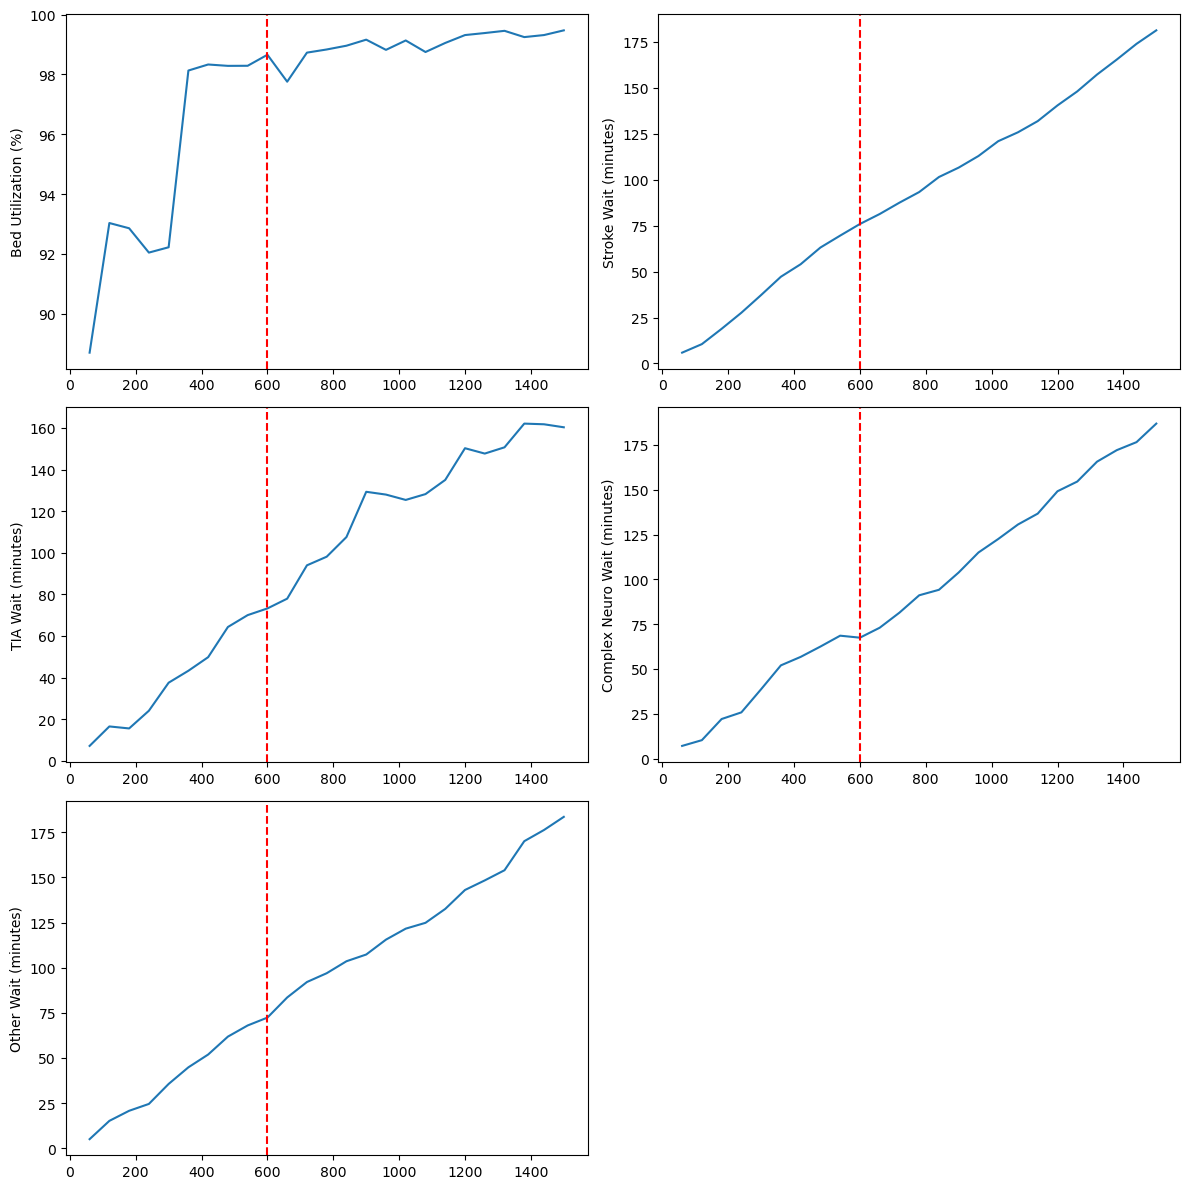

In [51]:
def time_series_inspection(results, warm_up=None):
    """
    Time series inspection method.

    Parameters:
    ----------
    results: dict or DataFrame
        The DataFrame containing the results, either from warmup_analysis 
        or another source.

    warm_up: int or None
        The warm-up period to display on the graphs (optional).

    Returns:
    -------
    fig: matplotlib.figure.Figure
        The figure object containing the plots.

    ax: numpy.ndarray of matplotlib.axes._axes.Axes
        The axes objects containing the individual plots.
    """

    df_warmup, df_pivot = results 


    fig, ax = plt.subplots(3, 2, figsize=(12, 12))
    ax = ax.flatten() 

    # Plot each metric
    ax[0].plot(df_warmup.groupby('time')['Bed_Utilization'].mean())  
    ax[1].plot(df_warmup.groupby('time')['Stroke_Wait'].mean())  
    ax[2].plot(df_warmup.groupby('time')['TIA_Wait'].mean())  
    ax[3].plot(df_warmup.groupby('time')['ComplexNeuro_Wait'].mean()) 
    ax[4].plot(df_warmup.groupby('time')['Other_Wait'].mean())  

    # Set the label of each chart
    labels = [
        "Bed Utilization (%)",
        "Stroke Wait (minutes)",
        "TIA Wait (minutes)",
        "Complex Neuro Wait (minutes)",
        "Other Wait (minutes)",
    ]
    for i, label in enumerate(labels):
        ax[i].set_ylabel(label)

    if warm_up is not None:
        for i in range(5):
            ax[i].axvline(x=warm_up, color="red", ls="--")

    # Remove empty subplot if it exists
    if len(ax) > 5:
        fig.delaxes(ax[5])

    plt.tight_layout() 
    return fig, ax

# Run and test
RUN_LENGTH = 1445
N_REPS = 6
scenario = Scenario()

print("Running warm-up analysis with replications. Please wait...", end=" => ")
results = warmup_analysis(scenario, rc_period=RUN_LENGTH, n_reps=N_REPS)
print("done.")


fig, ax = time_series_inspection(results, warm_up=600)
plt.show()


## 5.2 Rerunning the model with the warm up time

In [52]:
# Set model's warmup period
AUDIT_INTERVAL = 120
WARM_UP = 600
RC_PERIOD = 1445
N_REPS = 80

# Default scenario
args = Scenario()

# Run multiple replications (without warm_up)
print("Running multiple replications", end=" => ")
replications = multiple_replications(args, rc_period=RC_PERIOD, n_reps=N_REPS)
print("done.\n")

# Show results summary rounded to 2 decimal places
replications.describe().round(2)

Running multiple replications => done.



,Bed_Utilization (%),Stroke_Wait,TIA_Wait,ComplexNeuro_Wait,Other_Wait
count,80.00,80.00,80.00,80.00,80.00
mean,99.31,280.22,281.91,278.69,281.00
std,0.26,15.46,20.22,16.92,17.62
min,98.44,247.09,237.89,239.87,245.54
25%,99.20,270.18,268.42,264.82,266.99
50%,99.33,280.50,278.15,278.79,280.59
75%,99.49,290.15,295.12,290.65,290.59
max,99.72,317.01,343.07,315.55,330.72


# 6.0 Selecting the number of replications to run

## 6.1 Confidence interval
The confidence_interval_method calculates the minimum number of replications needed for a performance metric to achieve a specified confidence interval precision. It computes the cumulative mean and standard deviation for each replication, then calculates the upper and lower bounds of the confidence interval. The function stops once the width of the interval falls below the desired precision. The method takes parameters such as the array of replications, confidence level (alpha), target precision (desired_precision), minimum replications (min_rep), and rounding precision (decimal_places). It returns the recommended number of replications and a DataFrame with metrics like the mean, cumulative mean, standard deviation, and confidence intervals.

In [53]:
def confidence_interval_method(
    replications,
    alpha=0.05,
    desired_precision=0.05,
    min_rep=5,
    decimal_place=2,
):
    """
    Determines the required number of replications based on
    confidence intervals.

    Parameters:
    ----------
    replications: array-like
        Array of replications of a performance metric.

    alpha: float, optional (default=0.05)
        Confidence level for the interval.

    desired_precision: float, optional (default=0.05)
        Target mean deviation from the confidence interval.

    min_rep: int, optional (default=5)
        Minimum number of replications before applying precision target.

    decimal_place: int, optional (default=2)
        Rounds the results to specified decimal places.

    Returns:
    --------
        tuple: (int, pd.DataFrame)
    """
    n = len(replications)
    cumulative_mean = [replications[0]]
    running_var = [0.0]

    for i in range(1, n):
        new_mean = cumulative_mean[i - 1] + (
            (replications[i] - cumulative_mean[i - 1]) / (i + 1)
        )
        cumulative_mean.append(new_mean)

        # Running biased variance
        new_var = running_var[i - 1] + (
            (replications[i] - cumulative_mean[i - 1])
            * (replications[i] - cumulative_mean[i])
        )
        running_var.append(new_var)

    # Unbiased std dev = running_var / (n - 1)
    with np.errstate(divide="ignore", invalid="ignore"):
        running_std = np.sqrt(running_var / np.arange(n))

    # Half width of interval
    dof = len(replications) - 1
    t_value = t.ppf(1 - (alpha / 2), dof)

    with np.errstate(divide="ignore", invalid="ignore"):
        std_error = running_std / np.sqrt(np.arange(1, n + 1))

    half_width = t_value * std_error

    # Upper and lower confidence interval
    upper = cumulative_mean + half_width
    lower = cumulative_mean - half_width

    # Mean deviation
    with np.errstate(divide="ignore", invalid="ignore"):
        deviation = (half_width / cumulative_mean) * 100

    # Combine results into a DataFrame
    results = pd.DataFrame(
        [replications, cumulative_mean, running_std, lower, upper, deviation]
    ).T
    results.columns = [
        "Mean",
        "Cumulative Mean",
        "Standard Deviation",
        "Lower Interval",
        "Upper Interval",
        "% deviation",
    ]
    results.index = np.arange(1, n + 1)
    results.index.name = "replications"

    # Initialize n_reps
    n_reps = -1

    # Find the minimum required replications
    try:
        condition = (
            results.iloc[min_rep:]["% deviation"] <= desired_precision * 100
        )
        n_reps = min_rep + condition.idxmax()  # Find the first replication that meets the condition
    except IndexError:
        warnings.warn("WARNING: Replications do not reach desired precision")
    
    return n_reps, results.round(decimal_place)


# APPLY CONFIDENCE INTERVAL METHOD
stroke_wait_means = replications["Stroke_Wait"].dropna().values

# Run confidence interval analysis
n_reps, ci_results = confidence_interval_method(stroke_wait_means)

# Display results
print(f"Recommended number of replications: {n_reps}")
print(ci_results.head())

Recommended number of replications: 11
                Mean  Cumulative Mean  Standard Deviation  Lower Interval  \
replications                                                                
1             247.09           247.09                 NaN             NaN   
2             276.94           262.02               21.11          232.31   
3             297.29           273.77               25.25          244.76   
4             272.83           273.54               20.62          253.02   
5             272.70           273.37               17.86          257.47   

              Upper Interval  % deviation  
replications                               
1                        NaN          NaN  
2                     291.73        11.34  
3                     302.79        10.60  
4                     294.06         7.50  
5                     289.27         5.82  


In [54]:
ci_results.head()

,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
1,247.09,247.09,NaN,NaN,NaN,NaN
2,276.94,262.02,21.11,232.31,291.73,11.34
3,297.29,273.77,25.25,244.76,302.79,10.60
4,272.83,273.54,20.62,253.02,294.06,7.50
5,272.70,273.37,17.86,257.47,289.27,5.82


## 6.2 Plotting the confidence intervals
The plot_confidence_interval_method function plots the cumulative mean and confidence intervals for a performance metric, marking the recommended number of replications (n_reps) with a red dashed line. It takes the conf_ints results, metric_name, and an optional figsize to generate and return the plot.









In [55]:
def plot_confidence_interval_method(
    n_reps, conf_ints, metric_name, figsize=(12, 4)
):
    """
    Plot the confidence intervals and cumulative mean

    Parameters:
    ----------
    n_reps: int
        minimum number of reps selected

    conf_ints: pandas.DataFrame
       results of the `confidence_interval_method` function

    metric_name: str
        Name of the performance measure

    figsize: tuple, optional (default=(12,4))
        The size of the plot

    Returns:
    -------
        matplotlib.pyplot.axis
    """
    # plot cumulative mean + lower/upper intervals
    ax = conf_ints[
        ["Cumulative Mean", "Lower Interval", "Upper Interval"]
    ].plot(figsize=figsize)
    # add the
    ax.axvline(x=n_reps, ls="--", color="red")

    ax.set_ylabel(f"cumulative mean: {metric_name}")

    return ax

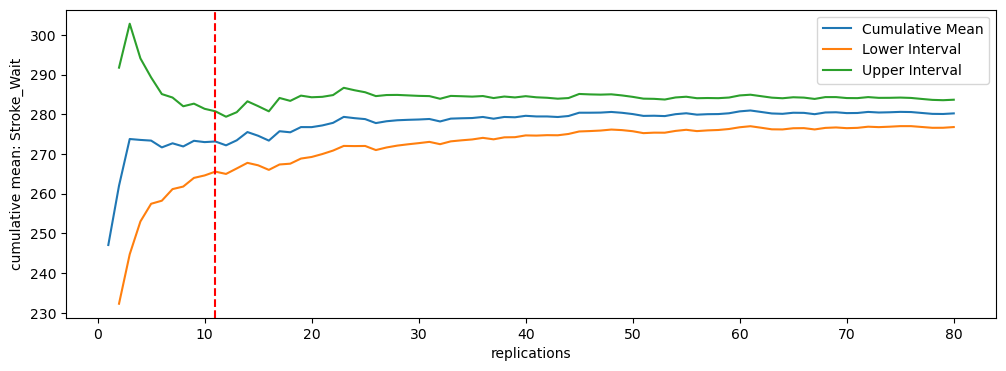

In [56]:
ax = plot_confidence_interval_method(
    n_reps, ci_results, metric_name="Stroke_Wait"
)

In [57]:
# Define lookahead range (15 replications after n_reps)
lookahead = 15

ci_results.iloc[n_reps - 1:n_reps + lookahead]

,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
11,274.83,273.15,12.65,265.56,280.75,2.78
12,261.50,272.18,12.53,264.98,279.38,2.64
13,288.52,273.44,12.82,266.36,280.52,2.59
14,302.51,275.52,14.56,267.77,283.26,2.81
15,261.67,274.59,14.48,267.15,282.04,2.71
16,255.03,273.37,14.82,266.00,280.74,2.70
17,313.46,275.73,17.33,267.36,284.10,3.03
18,270.97,275.46,16.85,267.56,283.37,2.87
19,300.34,276.77,17.34,268.85,284.69,2.86



Minimum number of reps for 5% precision: 11



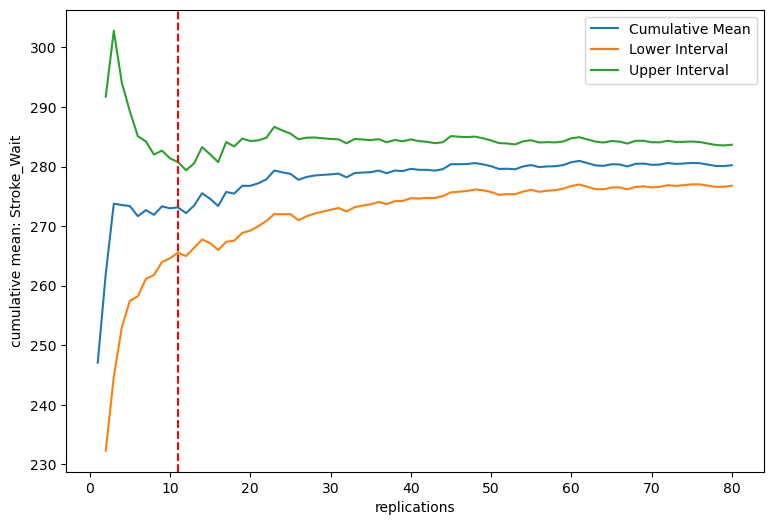

In [58]:
# Run the confidence interval method on 'Stroke_Wait' replications
n_reps, conf_ints = confidence_interval_method(
    replications["Stroke_Wait"].to_numpy(),
    desired_precision=0.05,
    min_rep=5,
)

# Print the minimum number of replications needed
print(f"\nMinimum number of reps for 5% precision: {n_reps}\n")

# Plot the confidence intervals
ax = plot_confidence_interval_method(
    n_reps, conf_ints, metric_name="Stroke_Wait", figsize=(9, 6)
)

# 6.3 Scenarios analysis
This script simulates bed utilization in an Acute Stroke Unit across different scenarios with varying bed counts. It defines constants for warm-up and results collection periods, ensuring data accuracy. The calculate_bed_utilization function computes bed usage after warm-up, capped at 100%. The run_simulation function executes the model for each scenario, while get_scenarios generates multiple scenarios with different bed capacities. Simulations run for each scenario, storing results in a dictionary. Finally, a bar chart visualizes bed utilization across scenarios, enhancing comparison and interpretation.

Scenario: beds_10, Bed Utilization: 100.00%
Scenario: beds_20, Bed Utilization: 100.00%
Scenario: beds_30, Bed Utilization: 78.53%
Scenario: beds_40, Bed Utilization: 58.45%


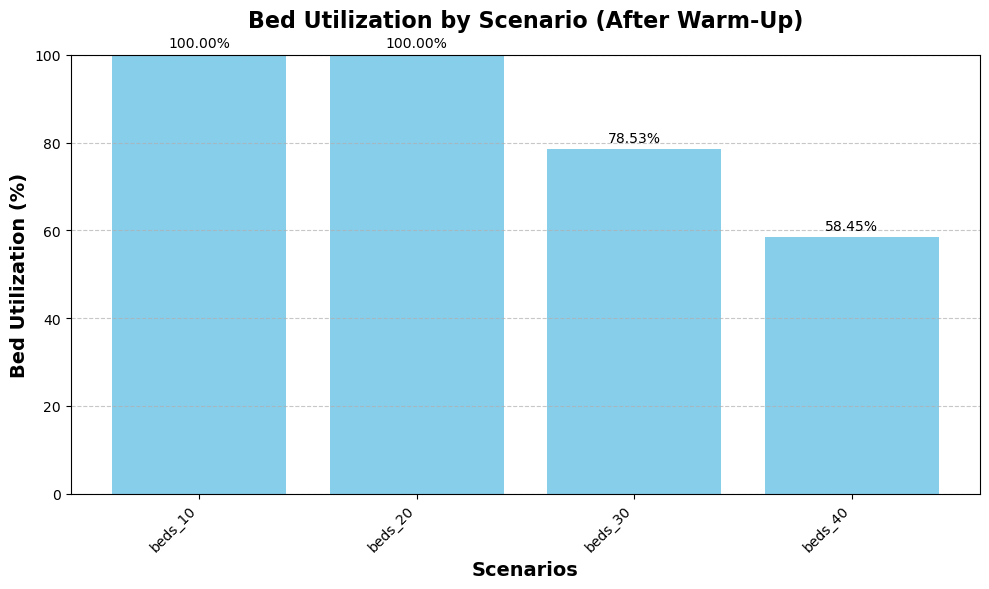

In [59]:
# Constants for warm-up and results collection
AUDIT_INTERVAL = 60
WARM_UP = 600
RC_PERIOD = 1445


def calculate_bed_utilization_warmup(model, start_time):
    """Calculate bed utilization after warm-up, capped at 100%."""
    total_bed_time = sum(
        min(p.length_of_stay, model.env.now - start_time)
        for p in model.patients
        if p.length_of_stay > 0 and (model.env.now - p.time_to_bed) >= start_time
    )

    total_time = (model.env.now - start_time) * model.args.unit_beds_capacity

    utilization = (total_bed_time / total_time) * 100 if total_time > 0 else 0
    return min(utilization, 100)  # Cap at 100%


def run_simulation(scenario):
    """
    Runs a single simulation with a given scenario and returns bed utilization.
    """
    env = simpy.Environment()
    model = AcuteStrokeUnit(env, scenario)

    # Start the arrival processes
    model.start_patient_arrivals()

    # Run the simulation for warm-up + results collection period
    env.run(until=WARM_UP + RC_PERIOD)

    # Calculate bed utilization after warm-up using the correct function
    return calculate_bed_utilization_warmup(model, WARM_UP)  # Call the correct function


def get_scenarios():
    """Returns a dictionary of scenarios with different bed counts."""
    scenarios = {}
    bed_counts = [10, 20, 30, 40]  # Example bed counts

    for bed_count in bed_counts:
        scenario = Scenario()
        scenario.unit_beds = bed_count
        scenario.unit_beds_capacity = bed_count
        scenarios[f"beds_{bed_count}"] = scenario

    return scenarios


# Create scenarios and store results
scenarios = get_scenarios()
results = {}

# Run simulations for each scenario and store results
for scenario_name, scenario in scenarios.items():
    bed_utilization_warmup = run_simulation(scenario)
    results[scenario_name] = bed_utilization_warmup

    print(
        f"Scenario: {scenario_name}, "
        f"Bed Utilization: {bed_utilization_warmup:.2f}%"
    )

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color="skyblue")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Labels and title with improved font sizes and styling
plt.xlabel("Scenarios", fontsize=14, fontweight='bold')
plt.ylabel("Bed Utilization (%)", fontsize=14, fontweight='bold')
plt.title("Bed Utilization by Scenario (After Warm-Up)", fontsize=16, 
          fontweight='bold', pad=20)

# Y-axis limits
plt.ylim(0, 100)

# Add value labels on top of each bar
for i, (scenario, utilization) in enumerate(results.items()):
    plt.text(i, utilization + 1, f"{utilization:.2f}%", ha="center", va="bottom")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Adjust layout and display the chart
plt.tight_layout()
plt.show()